# 1. Importing library & note of data

In [29]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -information about basis set files:
### ---for model_1 with 6 references, the file is: 'data/UV_spectra/Basis_set_6refs_0.5mM.csv'
### ---for model_2 with 11 references, the file is: 'data/UV_spectra/Basis_set_11refs_0.5mM.csv'
### ---for model_3 with PCA clustered references, the file is: 'data/UV_spectra/Basis_set_11refs_with_PCA_0.5mM.csv'

# -information about sample spectra files:
### ---for 1st round screnning with 11 metals (model_1), the file is: 'data/UV_spectra/Sample_crude_spectra_11metals.csv'
### ---for 2nd round screnning with 6 metals (model_2 & model_3), the file is: 'data/UV_spectra/Sample_crude_spectra_6metals.csv'

# -Here spectra unmixing of model_1 is show as working example, to test model_2 or model_3, changing the basis set and sample spectra according.


# 2. Working example: spectral unmixing of model_1

## 2.1 Loading spectra file

In [ ]:
# change the file names here to test different models
sample_file = 'data/UV_spectra/Sample_crude_spectra_11metals.csv'
basis_set_file = 'data/UV_spectra/Basis_set_6refs_0.5mM.csv'

# figure parameter
num_per_row = 5

# spectrum fitting range
spectrum_low = 225
spectrum_high = 310

In [24]:
# loading reference of solvent
ref_solvent = np.load('data/UV_spectra/bkg_spectrum.npy')
ref_solvent = pd.DataFrame(ref_solvent).set_index(0)
ref_solvent = ref_solvent.loc[str(spectrum_low):str(spectrum_high+1)]

# loading basis set and sample spectra, bkg of sovent already subtracted
X_ori = pd.read_csv(basis_set_file, index_col=0)
X = X_ori[(X_ori.index >= spectrum_low) & (X_ori.index <= spectrum_high)]

y_ori = pd.read_csv(sample_file, index_col=0)
y = y_ori[(y_ori.index >= spectrum_low) & (y_ori.index <= spectrum_high)]

# subtract solvent background for sample spectra
y = y.subtract(ref_solvent[1], axis=0)

y_pred = pd.DataFrame(index=y.index, columns=y.columns)


## 2.2 Plotting of spectra in basis set

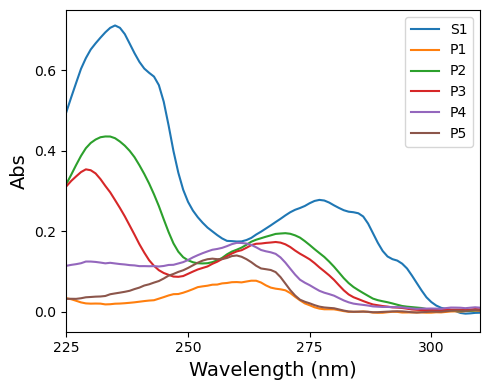

In [43]:
# create ref df
plt.figure(figsize=(5, 4))
for ind, col in X.items():
    sns.lineplot(x=X.index, y=col, label=ind)

plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Abs', fontsize=14)
plt.xticks(np.arange(225, 310, 25))
plt.yticks(np.arange(0, 0.71, 0.2))
# set y range
plt.xlim(225,310)
plt.ylim(-0.05, 0.75)
plt.legend()
plt.tight_layout()
plt.show()

## 2.3 Spectral unmixing

In [25]:
concentration = pd.DataFrame(columns = X.columns)
bias = pd.DataFrame(columns = ['b'])
error = pd.DataFrame(columns = ['MSE', 'MAE', 'R2', 'RMSE'])

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming: X, df_y, concentration, bias, error, y_pred, std_dev are all defined

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Ensure std_dev DataFrame has the correct columns (matching X)
std_dev = pd.DataFrame(columns=X.columns)

# Loop over each target
for ind, col in y.items():
    model = LinearRegression(fit_intercept=True, positive=True)
    model.fit(X, col)
    predictions = model.predict(X)

    # Store coefficients and intercept
    concentration.loc[ind] = model.coef_
    bias.loc[ind] = model.intercept_
    y_pred[ind] = predictions

    # Store error metrics
    error.loc[ind] = [
        mean_squared_error(col, predictions),
        mean_absolute_error(col, predictions),
        r2_score(col, predictions),
        root_mean_squared_error(col, predictions)
    ]

    residual_var = mean_squared_error(col, predictions)

    # Add intercept column
    X_design = np.hstack([np.ones((y.shape[0], 1)), X.values])

    # Use pseudo-inverse for stability
    cov_matrix = residual_var * np.linalg.pinv(X_design.T @ X_design)

    # Extract standard deviations of coefficients (skip intercept)
    coef_std_errors = np.sqrt(np.diag(cov_matrix)[1:])
    std_dev.loc[ind] = coef_std_errors

In [ ]:
# Convert concentration from arbitrary units to mM
# since basis set concentration is 0.5 mM
real_concentration = concentration * 0.5

# initial concentration of substrate after dilution is calibrated as 0.37 mM
estimated_yield = real_concentration/0.37 * 100  

# export estimated yield to CSV if needed
# estimated_yield.to_csv('results/UV_unmixing_estimated_yield_model1_11metals.csv')

## 2.4 Visualization of unmixing result

In [ ]:
ref_to_plot = X.columns
df_y = y

def plot_fitting_curve(index_to_plot):
    """index_to_plot: list of sample indices to plot"""
    
    row_num = len(index_to_plot) // num_per_row + (len(index_to_plot) % num_per_row > 0)
    row = -1

    # Multiple rows case
    if row_num > 1:
        fig, axes = plt.subplots(row_num, num_per_row, figsize=(5*num_per_row, 4*row_num), constrained_layout=True)

        # Ensure axes is 2D
        axes = axes.reshape((row_num, num_per_row))

        for count, i in enumerate(index_to_plot):
            row = count // num_per_row
            col = count % num_per_row

            ax = axes[row][col]
            sns.lineplot(x=df_y.index, y=df_y.iloc[:, i], label='sample', ax=ax)
            sns.lineplot(x=df_y.index, y=y_pred.iloc[:, i], label='fit', ax=ax)

            for ind, plot in enumerate(ref_to_plot):
                sns.lineplot(
                    x=df_y.index,
                    y=X[plot] * concentration.iloc[i, ind],
                    label=plot,
                    ax=ax,
                    lw=0.4
                )
            ax.set_title(f'Sample {i}')
    else:
        fig, axes = plt.subplots(1, len(index_to_plot), figsize=(5*len(index_to_plot), 4), constrained_layout=True)
        if len(index_to_plot) == 1:
            axes = [axes]  # Make iterable

        for j, i in enumerate(index_to_plot):
            ax = axes[j]
            sns.lineplot(x=df_y.index, y=df_y.iloc[:, i], label='sample', ax=ax)
            sns.lineplot(x=df_y.index, y=y_pred.iloc[:, i], label='fit', ax=ax)

            for ind, plot in enumerate(ref_to_plot):
                sns.lineplot(
                    x=df_y.index,
                    y=X[plot] * concentration.iloc[i, ind],
                    label=plot,
                    ax=ax,
                    lw=0.4
                )
            ax.set_title(f'Sample {i}')

    plt.show()


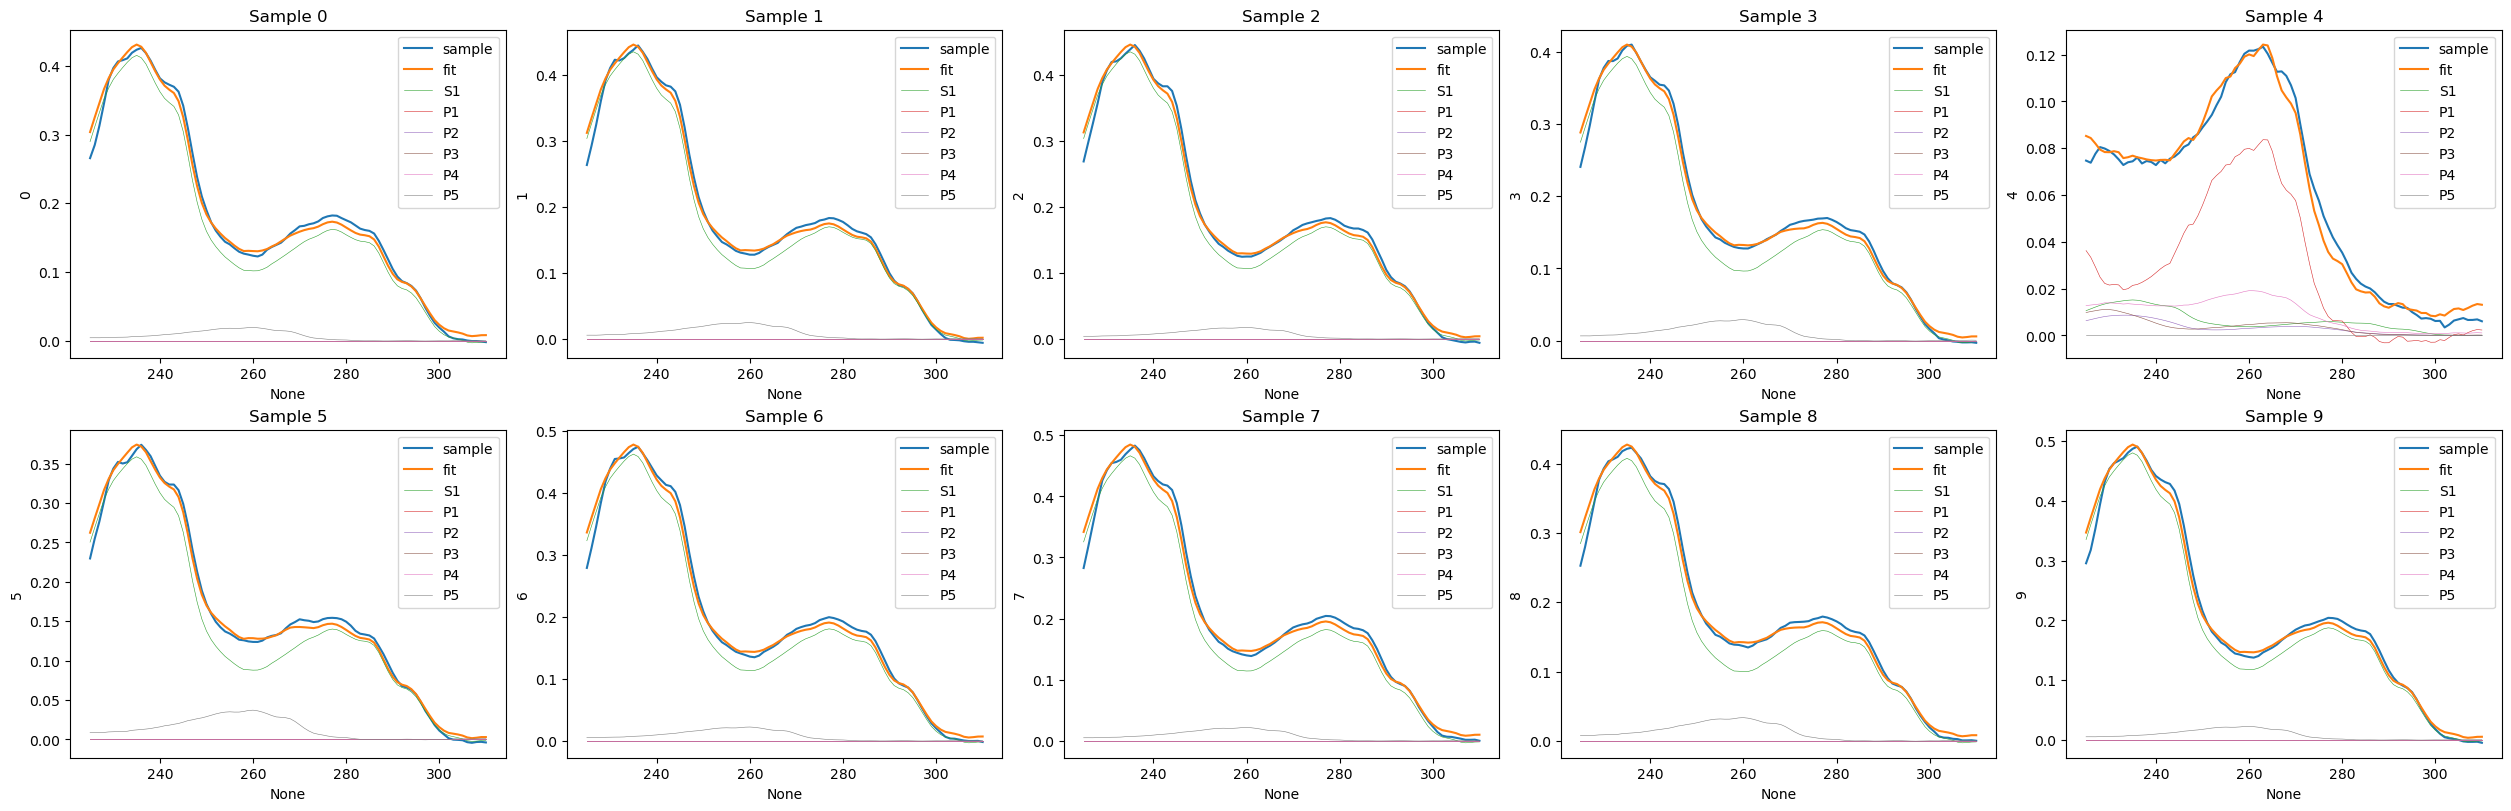

In [42]:
plot_fitting_curve(range(10))

## 2.5 Visualization of yield uncertainty

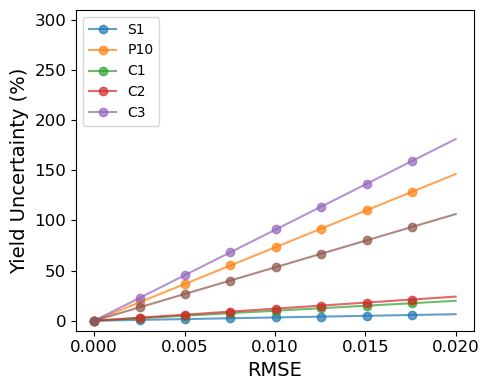

In [ ]:
cov_diag = np.diag(cov_matrix/residual_var)
ks = cov_diag[1:]

# Define x values
x = np.linspace(0, 0.02, 200)

# Create the plot
plt.figure(figsize=(5, 4))

for i, k in enumerate(ks):
    y = np.sqrt(k * x**2) / 0.75 * 100  # uncertainty calculation, here 0.75 is norlizing factor calculated based on initial substrate concentration (0.374 mM)
    plt.plot(x, y, label=f'k = {k}', marker='o', markevery=25, alpha=0.7)  # markevery shows some markers for clarity

#plt.title('Plots of y = k * x^2 for various k')
plt.xlabel('RMSE')
plt.ylabel('Yield Uncertainty (%)')

# ['S1', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6','P7','P8', 'P9','P10'], ['S1', 'P10', 'C1', 'C2', 'C3']
plt.legend(['S1', 'P10', 'C1', 'C2', 'C3'], loc='upper left')
# set the position of legend
#plt.grid(True)
plt.xticks(np.arange(0, 0.021, 0.005))
plt.yticks(np.arange(0, 301, 50))
# set y range
plt.ylim(-10, 310)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Yield Uncertainty (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
